In [3]:
import numpy as np
import pandas as pd
import xarray as xr

import holoviews as hv
from holoviews import opts
import hvplot.xarray
import hvplot.networkx as hvnx

from pathlib import Path
from tqdm.notebook import tqdm

import networkx as nx
import geonetworkx as gnx

import warnings

warnings.filterwarnings('ignore')
hv.extension('bokeh')

In [4]:
# quick and simple implementation without landlab
river_network_pts_fn = Path('../../data-cumberland/cumberland_rivreg/cumberland_rivreg_pts.geojson')
river_network_fn = Path('../../data-cumberland/cumberland_rivreg/cumberland_rivreg.geojson')

G = gnx.read_geofiles(river_network_pts_fn, river_network_fn, directed=True)
G

{0: Text(-0.9703534135984979, -0.9411394452270292, '0'),
 1: Text(1.0, 0.21235813584724236, '1'),
 2: Text(0.37965635874322456, 0.24123043814608816, '2'),
 3: Text(-0.0678284527274131, 0.40110059545085935, '3'),
 4: Text(-0.7587062120035868, -0.4738608898003975, '4'),
 5: Text(-0.40516838171036135, -0.714620354211408, '5'),
 6: Text(0.26179325052535646, 0.5662749674075487, '6'),
 7: Text(0.8509274475462317, 0.6299295176478622, '7'),
 8: Text(-0.2903205967749545, 0.07872703473923393, '8')}

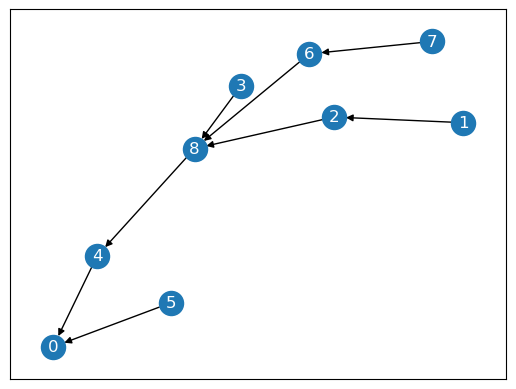

In [5]:
# plot reservoir network

pos = nx.drawing.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
# nx.draw_networkx_labels(G, pos, labels={node:G.nodes[node]['name'] for node in G.nodes},font_color='red')
nx.draw_networkx_labels(G, pos,font_color='white')

In [38]:
class Reservoir:
    def __init__(self, node, start_time='2000-01-01', **kwargs):
        self.node = node

        self.reservoir_breadth = 500  # m
        self.reservoir_depth = 500    # m
        self.outlet_height = 0        # m
        self.outlet_diameter = 0.1    # m
        
        self.reaction_factor = 0.01  # 1/d
        self.storage = 1e4            # m3
        self.inflow = 0               # m3/d
        self.storage_change = np.nan
        self.time = start_time if isinstance(start_time, pd.Timestamp) else pd.to_datetime(start_time)

        self.outlet_area = np.pi * (self.outlet_diameter / 2) ** 2

        # calculate derived properties
        self.water_height = self.storage / (self.reservoir_breadth * self.reservoir_depth)
        self.height_above_outlet = max([0, self.water_height - self.outlet_height]) # return height above outlet, or 0 if below outlet
        self.outlet_velocity = np.sqrt(2 * g * self.height_above_outlet)
        self.outlet_flow = self.outlet_area * self.outlet_velocity

        self.FIRST_RUN = 1

    def update(self, inflow, algorithm='outlet', dt=1):
        """update for one time step

        Args:
            inflow (number): inflow rate (m3/d)
            dt (number): time step (1 day)
        """
        # prev_time = self.time
        # self.time += pd.Timedelta(seconds=dt)
        if self.FIRST_RUN:
            self.FIRST_RUN = 0  # if this is the first run, don't advance time
        else:
            self.time += pd.Timedelta(days=dt)
        
        self.inflow = inflow
        
        if algorithm == 'outlet':
            self._alg_outlet(dt)
        
        if algorithm == 'linear_reservoir':
            self._alg_linear_reservoir(dt)

    def _alg_linear_reservoir(self, dt):
        self.outflow = self.reaction_factor * self.storage
        self.storage_change = self.inflow - self.outflow
        self.storage += self.storage_change * dt

        return {
            'inflow': self.inflow,
            'outflow': self.outflow,
            'storage': self.storage,
            'storage_change': self.storage_change,
        }

    def _alg_outlet(self, dt):
        last_storage = self.storage
        self.storage += self.inflow * dt

        # using water height method
        self.water_height = self.storage / (self.reservoir_breadth * self.reservoir_depth)
        self.height_above_outlet = max([0, self.water_height - self.outlet_height])

        self.outlet_velocity = np.sqrt(2 * g * self.height_above_outlet) # m/s
        self.outflow = self.outlet_area * self.outlet_velocity # m3/d

        self.storage -= self.outflow * dt # update storage again after outflow is calcualted
        self.storage_change = self.storage - last_storage # calculate storage change
    
    def dumpds(self):
        return {
            'inflow': self.inflow,
            'outflow': self.outflow,
            'storage': self.storage,
            'storage_change': self.storage_change,
            'water_height': self.water_height,
            'height_above_outlet': self.height_above_outlet,
        }

In [52]:
g = 9.81 # m/s2

class ReservoirNetwork(nx.DiGraph):
    def __init__(self, network, start_time, *args, **kwargs):
        super().__init__(network, *args, **kwargs)
        # self.data = xr.open_dataset(data) if isinstance(data, str) \
        #     else data if isinstance(data, xr.Dataset) \
        #     else ValueError("Must provide either path of data file or as xr.Dataset")
        self.data = xr.Dataset(
            coords={
                'node': list(self.nodes),
                'time': pd.date_range(start_time, periods=1, freq='1D')
            }
        ) 
        self.network = {node: Reservoir(node) for node in self.nodes}
        self.time = start_time

        self.FIRST_RUN = 1

    def create_field(self, var, fill_value=0.0):
        """Create a new field if not already present in self.data"""
        if var not in self.data.variables:
            self.data[var] = xr.DataArray(
                data=np.full((len(self.nodes), len(self.data.time)), fill_value),
                dims=['node', 'time'],
                coords={'node': self.nodes, 'time': self.data.time}
            )

    def insert_new_time_step(self, time):
        """Insert a new time step and fill with np.nan for all variables"""
        if time not in self.data.time:
            data_vars = {}
            for var in self.data.variables:
                if var not in ['node', 'time']:
                    data_vars[var] = (['node', 'time'], np.full((len(self.nodes), 1), np.nan))
            new_timestep_ds = xr.Dataset(data_vars=data_vars, coords={'node': self.nodes, 'time': [self.time]})
            # self.data = xr.merge([self.data, new_timestep_ds])
            self.data = xr.concat([self.data, new_timestep_ds], dim='time')
        else:
            raise ValueError(f"Time {time} already exists in data.")

    def update(self, forcings, dt=1, algorithm='simple', reservoir_algorithm='outlet'):
        """Update the reservoir network for one time step.

        Args:
            dt (int, optional): time step in days. Defaults to 1 day.
            algorithm (str, optional): Defaults to 'simple'.
                - hydraulic - outflow from reservoir is simulated to estimate storage change. 
                - simple - requires storage change and unregulated inflow of previous node.
        """

        if self.FIRST_RUN:
            self.create_field('inflow', np.nan)
            self.create_field('outflow', np.nan)
            self.create_field('regulated_runoff', np.nan)
            self.create_field('natural_runoff', np.nan)
            self.create_field('theoretical_natural_runoff', np.nan)
            self.create_field('storage', np.nan)
            self.create_field('storage_change', np.nan)
            self.create_field('regulation', np.nan)
            self.FIRST_RUN = 0
        else:
            self.time += pd.Timedelta(days=dt)
            self.insert_new_time_step(self.time)
        
        # insert forcings into data
        for var in forcings.variables:
            if var not in ['node', 'time']:
                # if var not in self.data.variables:
                self.data[var] = forcings[var]#.sel(time=self.time)
                # else:
                #     self.data[var].loc[dict(time=self.time)] = forcings[var].sel(time=self.time)
        
        if algorithm == 'hydraulic':
            self._alg_hydraulic(forcings, dt, reservoir_algorithm=reservoir_algorithm)

        if algorithm == 'hydraulic_travel_time':
            self._alg_hydraulic_travel_time(forcings, dt)

        if algorithm == 'simple':
            self._alg_simple(forcings, dt)
        
        if algorithm == 'simple_obs_outflow':
            self._alg_simple_obs_outflow(forcings, dt)

        if algorithm == 'simple_travel_time':
            self._alg_simple_travel_time(forcings, dt)

    def _alg_simple(self, forcings, dt):
        for node in list(nx.topological_sort(self)):
            storage_change = float(forcings['storage_change'].sel(node=node, time=self.time))
            theoretical_natural_runoff = float(forcings['theoretical_natural_runoff'].sel(node=node, time=self.time))

            self.data['theoretical_natural_runoff'].loc[dict(node=node, time=self.time)] = theoretical_natural_runoff

            upstream_dams = list(self.predecessors(node))
            natural_runoff = theoretical_natural_runoff
            regulated_runoff = 0.0
            if len(upstream_dams) > 0:
                regulated_runoff = sum([float(self.data['outflow'].sel(node=n, time=self.time)) for n in upstream_dams])
                natural_runoff -= sum([float(self.data['theoretical_natural_runoff'].sel(node=n, time=self.time)) for n in upstream_dams])

            inflow = max([0, float(natural_runoff + regulated_runoff)])
            outflow = max([0, inflow - storage_change])
            regulation = theoretical_natural_runoff - inflow

            self.data['inflow'].loc[dict(node=node, time=self.time)] = inflow
            self.data['outflow'].loc[dict(node=node, time=self.time)] = outflow
            self.data['regulation'].loc[dict(node=node, time=self.time)] = regulation
            self.data['natural_runoff'].loc[dict(node=node, time=self.time)] = natural_runoff
            self.data['regulated_runoff'].loc[dict(node=node, time=self.time)] = regulated_runoff
            self.data['storage_change'].loc[dict(node=node, time=self.time)] = storage_change
    
    def _alg_simple_obs_outflow(self, forcings, dt):
        for node in list(nx.topological_sort(self)):
            storage_change = float(forcings['storage_change'].sel(node=node, time=self.time))
            theoretical_natural_runoff = float(forcings['theoretical_natural_runoff'].sel(node=node, time=self.time))

            self.data['theoretical_natural_runoff'].loc[dict(node=node, time=self.time)] = theoretical_natural_runoff

            upstream_dams = list(self.predecessors(node))
            natural_runoff = theoretical_natural_runoff
            regulated_runoff = 0.0
            if len(upstream_dams) > 0:
                regulated_runoff = sum([float(self.data['obs_outflow'].sel(node=n, time=self.time)) for n in upstream_dams])
                natural_runoff -= sum([float(self.data['theoretical_natural_runoff'].sel(node=n, time=self.time)) for n in upstream_dams])

            inflow = max([0, float(natural_runoff + regulated_runoff)])
            outflow = max([0, inflow - storage_change])
            regulation = theoretical_natural_runoff - inflow

            self.data['inflow'].loc[dict(node=node, time=self.time)] = inflow
            self.data['outflow'].loc[dict(node=node, time=self.time)] = outflow
            self.data['regulation'].loc[dict(node=node, time=self.time)] = regulation
            self.data['natural_runoff'].loc[dict(node=node, time=self.time)] = natural_runoff
            self.data['regulated_runoff'].loc[dict(node=node, time=self.time)] = regulated_runoff
            self.data['storage_change'].loc[dict(node=node, time=self.time)] = storage_change

    def _alg_simple_travel_time(self, forcings, dt):
        for node in list(nx.topological_sort(self)):
            storage_change = float(forcings['storage_change'].sel(node=node, time=self.time))
            unregulated_inflow = float(forcings['unregulated_inflow'].sel(node=node, time=self.time))

            upstreams = list(self.predecessors(node))
            upstream_outflow = 0.0
            upstream_unregulated_inflow = 0.0
            if len(upstreams) > 0:
                time_lags = [self.time - pd.to_timedelta(round(self.get_edge_data(upstream, node)['travel_time']), 'd') for upstream in upstreams]
                upstream_outflow = sum([float(self.data['outflow'].sel(node=n, time=t)) for n, t in zip(upstreams, time_lags)])
                upstream_unregulated_inflow = sum([float(self.data['unregulated_inflow'].sel(node=n, time=t)) for n, t in zip(upstreams, time_lags)])
            
            regulated_inflow = max([0, float(unregulated_inflow - upstream_unregulated_inflow + upstream_outflow)])
            outflow = max([0, regulated_inflow - storage_change])

            self.data['regulated_inflow'].loc[dict(node=node, time=self.time)] = regulated_inflow
            self.data['outflow'].loc[dict(node=node, time=self.time)] = outflow

    def _alg_hydraulic(self, forcings, dt, reservoir_algorithm='outlet'):
        for node in list(nx.topological_sort(self)):
            # get reservoir object
            res = self.network[node]
            # get inflow for this node
            natural_runoff = (forcings['natural_runoff'].sel(node=node, time=slice(self.time - pd.Timedelta(days=dt), self.time)).mean() * dt).data # m3

            # if there are upstream nodes, the inflow 
            regulated_runoff = 0
            theoretical_natural_runoff = natural_runoff.copy()
            upstreams = list(self.predecessors(node))
            if len(upstreams) > 0:
                # sum the outflow from upstream nodes to the inflow of this node
                regulated_runoff += sum([self.data['outflow'].sel(node=n, time=self.time) for n in upstreams]).data
                theoretical_natural_runoff += sum([self.data['theoretical_natural_runoff'].sel(node=n, time=self.time) for n in upstreams]).data
            
            inflow = natural_runoff + regulated_runoff
            res.update(inflow, dt=1, algorithm=reservoir_algorithm) # run one time-step of the reservoir model

            res_data = res.dumpds()

            self.data['inflow'].loc[dict(node=node, time=self.time)] = res_data['inflow']
            self.data['outflow'].loc[dict(node=node, time=self.time)] = res_data['outflow']
            self.data['regulation'].loc[dict(node=node, time=self.time)] = theoretical_natural_runoff - res_data['inflow']
            self.data['storage_change'].loc[dict(node=node, time=self.time)] = res_data['storage_change']
            self.data['storage'].loc[dict(node=node, time=self.time)] = res_data['storage']
            self.data['regulated_runoff'].loc[dict(node=node, time=self.time)] = regulated_runoff
            self.data['theoretical_natural_runoff'].loc[dict(node=node, time=self.time)] = theoretical_natural_runoff

    def _alg_hydraulic_travel_time(self, forcings, dt):
        for node in list(nx.topological_sort(self)):
            # get reservoir object
            res = self.network[node]
            # get inflow for this node
            natural_runoff = (forcings['natural_runoff'].sel(node=node, time=slice(self.time - pd.Timedelta(days=dt), self.time)).mean() * dt).data # m3

            # if there are upstream nodes, the inflow 
            regulated_runoff = 0
            theoretical_natural_runoff = natural_runoff.copy()
            upstreams = list(self.predecessors(node))
            if len(upstreams) > 0:
                # sum the outflow from upstream nodes to the inflow of this node
                time_lags = [self.get_edge_data(upstream, node)['travel_time'] for upstream in upstreams]
                #### NOTE: method='nearest' is used as of now to get the nearest available upstream outflow value to the self.time-time_lag time.
                ####       this must be handled later, either by interpolating, or using np.nan for the first few time steps.
                regulated_runoff += sum([self.data['outflow'].sel(node=n, time=self.time-pd.Timedelta(lag, 'D')) for n, lag in zip(upstreams, time_lags)]).data
                theoretical_natural_runoff += sum([self.data['theoretical_natural_runoff'].sel(node=n, time=self.time-pd.Timedelta(lag, 'D')) for n, lag in zip(upstreams, time_lags)]).data
            
            inflow = natural_runoff + regulated_runoff
            res.update(inflow, 1) # run one time-step of the reservoir model
            res_data = res.dumpds()

            # update data
            self.data['inflow'].loc[dict(node=node, time=self.time)] = res_data['inflow']
            self.data['outflow'].loc[dict(node=node, time=self.time)] = res_data['outflow']
            self.data['regulation'].loc[dict(node=node, time=self.time)] = theoretical_natural_runoff - res_data['inflow']
            self.data['storage_change'].loc[dict(node=node, time=self.time)] = res_data['storage_change']
            self.data['storage'].loc[dict(node=node, time=self.time)] = res_data['storage']
            self.data['regulated_runoff'].loc[dict(node=node, time=self.time)] = regulated_runoff
            self.data['theoretical_natural_runoff'].loc[dict(node=node, time=self.time)] = theoretical_natural_runoff

In [71]:
# aggregate
def aggregate(ds, frequency='weekly'):
    if frequency == 'weekly':
        resampled = ds.resample(time='1W').mean()
        resampled['dt'] = ds['time'].resample(time='1W').count()
    elif frequency == 'monthly':
        resampled = ds.resample(time='1M').mean()
        resampled['dt'] = ds['time'].resample(time='1M').count()
    elif frequency == 'annual':
        resampled = ds.resample(time='1Y').mean()
        resampled['dt'] = ds['time'].resample(time='1Y').count()
    else:
        raise ValueError(f'frequency {frequency} not supported')
    
    return resampled

def calculate_volumes(
        ds, 
        fluxes=['unregulated_inflow', 'obs_inflow', 'obs_outflow', 'obs_storage_change']
    ):
    """Calculate volume values using flow rates and ∆t

    Args:
        ds (xr.Dataset): Dataset containing flow rates in m3/day
    """
    for flux in fluxes:
        ds[flux] = ds[flux] * ds['dt']
        ds[flux].attrs['units'] = 'm3'
        ds[flux].attrs['long_name'] = f'Volume of {flux}'
        ds[flux].attrs['description'] = f'Volume of {flux} in m3'

    return ds

ds = xr.open_dataset('/water2/pdas47/2023_01_24-river-regulation/data-era5-2010_2021/regulation/regulation_data.insitu.nc')

start_time = pd.to_datetime('2010-10-01')
end_time = pd.to_datetime('2021-09-30')

subset = ds.sel(time=slice(start_time, end_time))
aggregated_subset = calculate_volumes(aggregate(subset, 'monthly'))

if start_time < aggregated_subset.time.min():
    start_time = aggregated_subset.time.min().values
if end_time > aggregated_subset.time.max():
    end_time = aggregated_subset.time.max().values

forcings = xr.Dataset(
    data_vars={
        'theoretical_natural_runoff': aggregated_subset['unregulated_inflow'],
        'storage_change': aggregated_subset['obs_storage_change'],
        'obs_inflow': aggregated_subset['obs_inflow'],
        'obs_outflow': aggregated_subset['obs_outflow']
    }
)

reservoir_network = ReservoirNetwork(G, start_time)

for timestep in tqdm(aggregated_subset.time.values):
    dt = aggregated_subset['dt'].sel(time=timestep).values.item()
    reservoir_network.update(forcings, dt, 'simple_obs_outflow')

reservoir_network.data

  0%|          | 0/132 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:                     (node: 9, time: 132)
Coordinates:
  * node                        (node) int64 0 1 2 3 4 5 6 7 8
  * time                        (time) datetime64[ns] 2010-10-31 ... 2021-09-30
Data variables:
    inflow                      (node, time) float64 2.679e+08 5.715e+08 ... 0.0
    outflow                     (node, time) float64 2.738e+08 5.447e+08 ... 0.0
    regulated_runoff            (node, time) float64 2.707e+08 4.18e+08 ... nan
    natural_runoff              (node, time) float64 -2.741e+06 ... 1.351e+08
    theoretical_natural_runoff  (time, node) float64 1.634e+08 ... 7.066e+08
    storage                     (node, time) float64 nan nan nan ... nan nan nan
    storage_change              (time, node) float64 -5.823e+06 ... nan
    regulation                  (node, time) float64 -1.045e+08 ... 7.066e+08
    obs_inflow                  (time, node) float64 5.902e+08 7.171e+03 ... nan
    obs_outflow                 (time, node) float64 5.96e+08 4.272e+06 ... nan

In [72]:
reservoir_network.data

<xarray.Dataset>
Dimensions:                     (node: 9, time: 132)
Coordinates:
  * node                        (node) int64 0 1 2 3 4 5 6 7 8
  * time                        (time) datetime64[ns] 2010-10-31 ... 2021-09-30
Data variables:
    inflow                      (node, time) float64 2.679e+08 5.715e+08 ... 0.0
    outflow                     (node, time) float64 2.738e+08 5.447e+08 ... 0.0
    regulated_runoff            (node, time) float64 2.707e+08 4.18e+08 ... nan
    natural_runoff              (node, time) float64 -2.741e+06 ... 1.351e+08
    theoretical_natural_runoff  (time, node) float64 1.634e+08 ... 7.066e+08
    storage                     (node, time) float64 nan nan nan ... nan nan nan
    storage_change              (time, node) float64 -5.823e+06 ... nan
    regulation                  (node, time) float64 -1.045e+08 ... 7.066e+08
    obs_inflow                  (time, node) float64 5.902e+08 7.171e+03 ... nan
    obs_outflow                 (time, node) float64 5.96e+08 4.272e+06 ... nan

In [73]:
ds['obs_outflow'].sel(node=0)

<xarray.DataArray 'obs_outflow' (time: 30316)>
[30316 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1938-10-01 1938-10-02 ... 2021-09-30
    node     int64 0

In [74]:
reservoir_network.data['obs_outflow'].sel(node=0).hvplot()

:Curve   [time]   (obs_outflow)

In [60]:
reservoir_network.data.to_netcdf('../../data-era5-2010_2021/regulation/regulation_data.insitu.obs_outflow.monthly-2.ERA5.nc')

In [61]:
node = 0

ds = reservoir_network.data
ds['obs_inflow'] = subset['obs_inflow']

ds['inflow'].sel(node=node).hvplot(label='inflow') * ds['obs_inflow'].sel(node=node).hvplot(label='observed') * ds['theoretical_natural_runoff'].sel(node=node).hvplot(label='TNR')

:Overlay
   .Curve.Inflow   :Curve   [time]   (inflow)
   .Curve.Observed :Curve   [time]   (obs_inflow)
   .Curve.TNR      :Curve   [time]   (theoretical_natural_runoff)

In [12]:
from bokeh.models.formatters import NumeralTickFormatter

# plot comparing downstream and upstream nodes
# node = 0
current_node_plot = ds['inflow'].sel(node=node).hvplot(label='inflow').opts(color='#069af3') * ds['obs_inflow'].sel(node=node).hvplot(label='observed').opts(color='k') * ds['theoretical_natural_runoff'].sel(node=node).hvplot(label='TNR').opts(color='green', line_dash='3 3')
current_node_plot = current_node_plot.opts(yformatter=NumeralTickFormatter(format='0.0a'))

upstreams = list(reservoir_network.predecessors(node))

plots = [current_node_plot]
for upstream in upstreams:
    upstream_plot = ds['inflow'].sel(node=upstream).hvplot(label='inflow').opts(color='#a2cffe') * ds['obs_inflow'].sel(node=upstream).hvplot(label='observed').opts(color='k') * ds['theoretical_natural_runoff'].sel(node=upstream).hvplot(label='TNR').opts(color='green', line_dash='dashed')
    upstream_plot *= ds['storage_change'].sel(node=upstream).hvplot(label='storage change').opts(color='gray')
    upstream_plot *= ds['outflow'].sel(node=upstream).hvplot(label='outflow').opts(color='red')
    upstream_plot = upstream_plot.opts(yformatter=NumeralTickFormatter(format='0.0a'), ylabel='inflow [m3]')
    plots.append(upstream_plot)

import panel as pn

hv.Layout(plots).cols(1)

:Layout
   .Overlay.I   :Overlay
      .Curve.Inflow   :Curve   [time]   (inflow)
      .Curve.Observed :Curve   [time]   (obs_inflow)
      .Curve.TNR      :Curve   [time]   (theoretical_natural_runoff)
   .Overlay.II  :Overlay
      .Curve.Inflow         :Curve   [time]   (inflow)
      .Curve.Observed       :Curve   [time]   (obs_inflow)
      .Curve.TNR            :Curve   [time]   (theoretical_natural_runoff)
      .Curve.Storage_change :Curve   [time]   (storage_change)
      .Curve.Outflow        :Curve   [time]   (outflow)
   .Overlay.III :Overlay
      .Curve.Inflow         :Curve   [time]   (inflow)
      .Curve.Observed       :Curve   [time]   (obs_inflow)
      .Curve.TNR            :Curve   [time]   (theoretical_natural_runoff)
      .Curve.Storage_change :Curve   [time]   (storage_change)
      .Curve.Outflow        :Curve   [time]   (outflow)

In [13]:
import scipy.stats as stats

def get_stats(obs, mod):
    corr, corr_p = stats.pearsonr(obs, mod)
    nse = 1 - (np.sum((obs - mod)**2)/np.sum((obs - np.mean(obs))**2))
    nse1 = 1 - (np.sum(np.abs(obs - mod))/np.sum(np.abs(obs - np.mean(obs))))
    rmse = np.sqrt(np.sum((obs-mod)**2)/len(mod))
    norm_rmse = rmse/(np.max(obs) - np.min(obs))
    mae = np.sum(np.abs(mod-obs))/len(mod)
    norm_mae = mae/(np.max(obs) - min(obs))
    kge = 1 - np.sqrt((corr-1)**2 +  (np.std(mod)/np.std(obs) - 1)**2 + (np.mean(mod)/np.mean(obs) - 1)**2) 

    # print({'pearson-r': corr, 'pearson-r p-val': corr_p, 'nse': nse, 'nse1': nse1, 'rmse': rmse, 'norm_rmse': norm_rmse, 'mae': mae, 'norm_mae': norm_mae, 'kge': kge})

    return {'pearson-r': corr, 'pearson-r p-val': corr_p, 'nse': nse, 'nse1': nse1, 'rmse': rmse, 'norm_rmse': norm_rmse, 'mae': mae, 'norm_mae': norm_mae, 'kge': kge}

In [14]:
node = 0

rr_res = ds[['obs_inflow', 'inflow']].sel(node=node).dropna(dim='time')

print('river regulation model results')
get_stats(rr_res['obs_inflow'].data, rr_res['inflow'].data)

river regulation model results


{'pearson-r': 0.8892402307703003,
 'pearson-r p-val': 3.6899871408912963e-39,
 'nse': 0.7668402321143792,
 'nse1': 0.5648635708925687,
 'rmse': 30805723.350669835,
 'norm_rmse': 0.10827387892807296,
 'mae': 21731511.59223077,
 'norm_mae': 0.07638045139459601,
 'kge': 0.8289195017552508}

In [15]:
# node = 0

rr_res = ds[['obs_inflow', 'theoretical_natural_runoff']].sel(node=node).dropna(dim='time')

print('TNR vs. Obs results')
get_stats(rr_res['obs_inflow'].data, rr_res['theoretical_natural_runoff'].data)

TNR vs. Obs results


{'pearson-r': 0.8224801403604757,
 'pearson-r p-val': 1.0193704812133831e-28,
 'nse': 0.5797977966081331,
 'nse1': 0.377815706792486,
 'rmse': 41355546.710564874,
 'norm_rmse': 0.1453536866046875,
 'mae': 31073025.0925619,
 'norm_mae': 0.10921337306393311,
 'kge': 0.7549518521791043}

In [16]:
regulated_runoff_hv = ds['regulated_runoff'].sel(node=node).hvplot(label='regulated_runoff').opts()
natural_runoff_hv = ds['natural_runoff'].sel(node=node).hvplot(label='natural_runoff').opts()
theoretical_natural_runoff_hv = ds['theoretical_natural_runoff'].sel(node=node).hvplot(label='theoretical_natural_runoff').opts()

regulated_runoff_hv * natural_runoff_hv * theoretical_natural_runoff_hv

:Overlay
   .Curve.Regulated_runoff           :Curve   [time]   (regulated_runoff)
   .Curve.Natural_runoff             :Curve   [time]   (natural_runoff)
   .Curve.Theoretical_natural_runoff :Curve   [time]   (theoretical_natural_runoff)

river regulation model results


{'pearson-r': 0.767809626405093,
 'pearson-r p-val': 1.876263319905805e-101,
 'nse': -1.660839785284454,
 'nse1': -0.05303249441256952,
 'rmse': 41341861.23498369,
 'norm_rmse': 0.2559436592661637,
 'mae': 21979820.099372625,
 'norm_mae': 0.13607504399160908,
 'kge': -0.25500646127679194}

In [ ]:
node = 2

rr_res = ds[['obs_inflow', 'regulated_runoff']].sel(node=node).dropna(dim='time')

print('river regulation model results')
get_stats(rr_res['obs_inflow'].data, rr_res['regulated_runoff'].data)

river regulation model results


{'pearson-r': 0.07374028307520886,
 'pearson-r p-val': 3.163007339486722e-10,
 'nse': -0.3283471376888307,
 'nse1': -0.0024450953594090663,
 'rmse': 43576395.257667534,
 'norm_rmse': 0.0794384311717526,
 'mae': 21962145.57125452,
 'norm_mae': 0.04003631734635355,
 'kge': -0.5702984511559932}

In [ ]:
hvds = hv.Dataset(ds['theoretical_natural_runoff'].sel(node=2) - ds['inflow'].sel(node=2), kdims=['time'], vdims=['regulation'])
hvds.to(hv.Curve)
# expected_regulation = ds['theoretical_natural_runoff'].sel(node=2) - ds['inflow'].sel(node=2)

# expected_regulation.hvplot('time')
# # ds['regulation'].sel(node=node).hvplot(label='regulation') * expected_regulation.hvplot(label='expected regulation')

:Curve   [time]   (regulation)

# Run model for Cumberland basin using `simple` reservoir network algorithm

{0: Text(-0.7807341667002776, 0.8634412467710831, '0'),
 1: Text(-0.4253456723912749, -0.7936047169819842, '1'),
 2: Text(-0.1534874749258655, -0.25314444599361496, '2'),
 3: Text(-0.40858283231846393, 0.3141190025896484, '3'),
 4: Text(-0.13963372016609193, 0.8428587910413774, '4'),
 5: Text(0.22464389731758966, 0.15053886302895078, '5'),
 6: Text(0.5766256019087326, -0.4196091311452532, '6'),
 7: Text(1.0, -0.890653235221262, '7'),
 8: Text(0.10651436727565178, 0.18605362591105712, '8')}

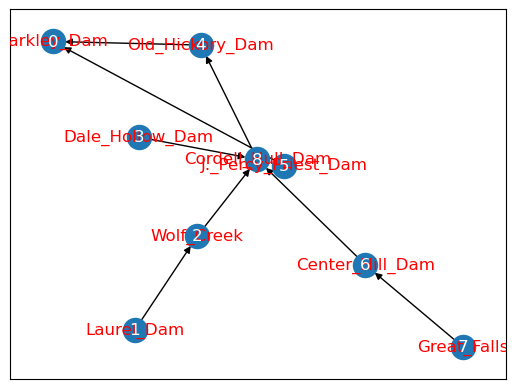

In [ ]:
# quick and simple implementation without landlab
river_network_pts_fn = Path('../../data-cumberland/cumberland_rivreg/cumberland_rivreg_pts.geojson')
river_network_fn = Path('../../data-cumberland/cumberland_rivreg/cumberland_rivreg.geojson')

G = gnx.read_geofiles(river_network_pts_fn, river_network_fn, directed=True)

pos = nx.drawing.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, labels={node:G.nodes[node]['name'] for node in G.nodes},font_color='red')
nx.draw_networkx_labels(G, pos,font_color='white')

In [ ]:
import matplotlib.pyplot as plt

# for timestep in tqdm(pd.date_range(start_time, end_time)):
#     reservoir_network.update(forcings, 1, 'simple')


# rr_network = []

# for node in list(nx.topological_sort(G)):
    
#     two_node_configuration = list(nx.dfs_tree(G, node, 1))
#     print(node, two_node_configuration)

    # subset_G = G.edge_subgraph(two_node_configuration)

    # start_time = pd.to_datetime('2012-01-01')
    # end_time = pd.to_datetime('2012-12-31')

    # reservoir_network = ReservoirNetwork(G, start_time)

    # for timestep in tqdm(pd.date_range(start_time, end_time)):
    #     reservoir_network.update(forcings, 1, 'simple')

    # rr_network.append(reservoir_network)

# rr_network = xr.concat([rr.data for rr in rr_network], dim='node')
# rr_network

In [ ]:
node = 8

ds = reservoir_network.data
ds['obs_inflow'] = subset['obs_inflow']

ds['inflow'].sel(node=node).hvplot(label='inflow') * ds['obs_inflow'].sel(node=node).hvplot(label='observed') * ds['theoretical_natural_runoff'].sel(node=node).hvplot(label='TNR')

:Overlay
   .Curve.Inflow   :Curve   [time]   (inflow)
   .Curve.Observed :Curve   [time]   (obs_inflow)
   .Curve.TNR      :Curve   [time]   (theoretical_natural_runoff)

In [ ]:
import scipy.stats as stats

def get_stats(obs, mod):
    corr, corr_p = stats.pearsonr(obs, mod)
    nse = 1 - (np.sum((obs - mod)**2)/np.sum((obs - np.mean(obs))**2))
    nse1 = 1 - (np.sum(np.abs(obs - mod))/np.sum(np.abs(obs - np.mean(obs))))
    rmse = np.sqrt(np.sum((obs-mod)**2)/len(mod))
    norm_rmse = rmse/(np.max(obs) - np.min(obs))
    mae = np.sum(np.abs(mod-obs))/len(mod)
    norm_mae = mae/(np.max(obs) - min(obs))
    kge = 1 - np.sqrt((corr-1)**2 +  (np.std(mod)/np.std(obs) - 1)**2 + (np.mean(mod)/np.mean(obs) - 1)**2) 

    # print({'pearson-r': corr, 'pearson-r p-val': corr_p, 'nse': nse, 'nse1': nse1, 'rmse': rmse, 'norm_rmse': norm_rmse, 'mae': mae, 'norm_mae': norm_mae, 'kge': kge})

    return {'pearson-r': corr, 'pearson-r p-val': corr_p, 'nse': nse, 'nse1': nse1, 'rmse': rmse, 'norm_rmse': norm_rmse, 'mae': mae, 'norm_mae': norm_mae, 'kge': kge}

In [ ]:
node = 6

rr_res = ds[['obs_inflow', 'inflow']].sel(node=node).dropna(dim='time')

print('river regulation model results')
get_stats(rr_res['obs_inflow'].data, rr_res['inflow'].data)

river regulation model results


{'pearson-r': 0.607544080371881,
 'pearson-r p-val': 0.0,
 'nse': 0.35151073030661373,
 'nse1': 0.36233784894170684,
 'rmse': 13895705.76179969,
 'norm_rmse': 0.0508976084469901,
 'mae': 5965414.902884377,
 'norm_mae': 0.021850300888317367,
 'kge': 0.5155753992825829}

In [ ]:
tnr_res = ds[['obs_inflow', 'theoretical_natural_runoff']].sel(node=node).dropna(dim='time')

print('Theoretical runoff results')
get_stats(tnr_res['obs_inflow'].data, tnr_res['theoretical_natural_runoff'].data)

Theoretical runoff results


{'pearson-r': 0.6477087021301894,
 'pearson-r p-val': 0.0,
 'nse': 0.3386711713552326,
 'nse1': 0.3125391870583786,
 'rmse': 14032593.340986831,
 'norm_rmse': 0.051399004383702936,
 'mae': 6431288.060401216,
 'norm_mae': 0.023556715083013442,
 'kge': 0.6203846115288791}